In [1]:
# Import modules

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
import pandas as pd
from tabulate import tabulate

In [2]:
# p(s|t), used in Q.4-Q.6
def p_st(mu_s, covar_s, covar_ts, A, ATranspose, t):
    
    mu_sTranspose = mu_s[:,None]
    covar_sInv = np.linalg.inv(covar_s)
    
    covar_st = np.linalg.inv(covar_sInv + (ATranspose * (1/covar_ts) * A))
    mu_st = covar_st @ (covar_sInv @ mu_sTranspose + ATranspose * (1/covar_ts) *t)
    
    return stats.multivariate_normal.rvs(np.ravel(mu_st), covar_st)

# p(t|s), truncated gaussian, used in Q.4-Q.6
def p_ts(y, s1, s2, covar_s, covar_ts, A, ATranspose):
    
    # Player 1 wins
    if y == 1:
        ing1 = 0
        ing2 = np.Inf
        
    # Player 2 wins
    else:
        ing1 = -np.Inf
        ing2 = 0
    
    mu_t = s1 - s2
    sigma_t  = np.sqrt(covar_ts +A @ covar_s @ ATranspose)
    
    return stats.truncnorm.rvs((ing1 - mu_t) / sigma_t, (ing2 - mu_t) / sigma_t, loc=mu_t, scale=sigma_t)

# p(s), used in Q.4
def p_s(x, mu, sigma):
    
    return stats.norm.pdf(x, mu, sigma)


In [7]:
# Gibbs sampler, used in Q.4-Q.6
def gibbs(K, mu_s, cov_s, cov_ts, t0, burn_in=0, y=1):
    
    A = np.array([1, -1])
    ATranspose = A[:,None]
    
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    
    s1[0] = mu_s[0] 
    s2[0] = mu_s[1]
    t[0] = t0

    for k in range(K - 1):
        
        s1[k+1], s2[k+1] = p_st(mu_s, covar_s, covar_ts, A, ATranspose, t[k])
        t[k+1] = p_ts(y, s1[k+1], s2[k+1], covar_s, covar_ts, A, ATranspose)
        
    return s1[burn_in::], s2[burn_in::], t[burn_in::]

In [8]:
def trueskillGaussDist(X, s1, s2):
    
    plt.plot(X, p_s(X, m_s2, var_s2), label="p(s1) and p(s2)", linestyle="dashed", color="orange")
    plt.plot(X, p_s(X, np.mean(s1), np.std(s1)), label="Gibbs: p(s1|y=1)", color="blue")
    plt.plot(X, p_s(X, np.mean(s2),np.std(s2)), label="Gibbs: p(s2|y=1)", color="purple")
    plt.legend()
    plt.show()

In [21]:
Klist = [250, 500, 700, 800, 1000, 2500, 5000]
#Klist = [500, 600, 700, 750, 800, 850]
burn_in = 40
def performance_check(Kl, mu_s, covar_s, covar_ts, t0, burn_in):
    
    x = np.linspace(0, 50, 1000)
    for k in Kl:
        
        t_start = time.perf_counter()
        s1, s2, t = gibbs(k+burn_in, mu_s, covar_s, covar_ts, t0, burn_in)
        t_stop = time.perf_counter()
        
        plt.plot(x, p_s(x, np.mean(s1), np.std(s1)), label="S1 post", color="red")
        plt.hist(s1,bins=30, density=True)
        plt.title("K = {}, time = {:.2f}".format(k, (t_stop - t_start)))
        plt.show()
        


In [10]:
# Used for Q.5

def dataPreprocesser(df):
    
    # Create a new column for the result and filter the draws
    df['result'] = np.sign(df["score1"] - df["score2"])
    df = df.loc[df['result'] != 0]
    
    # Create new dataframe for club data
    df2 = pd.DataFrame()
    df2["club"] = df["team1"].unique()
    df2["win"], df2["loss"], df2["mean"], df2["variance"] = 0, 0, 25, 25/3
    
    # Compute results for all matches based on scores
    for i, row in df.iterrows():
        if row["result"] == 1:
            df2.loc[df2["club"] == row["team1"], "win"] += 1
            df2.loc[df2["club"] == row["team2"], "loss"] += 1
        elif row["result"] == -1:
            df2.loc[df2["club"] == row["team2"], "win"] += 1
            df2.loc[df2["club"] == row["team1"], "loss"] += 1
        else:
            print("Dataframe contains draws.")

    return df, df2
    


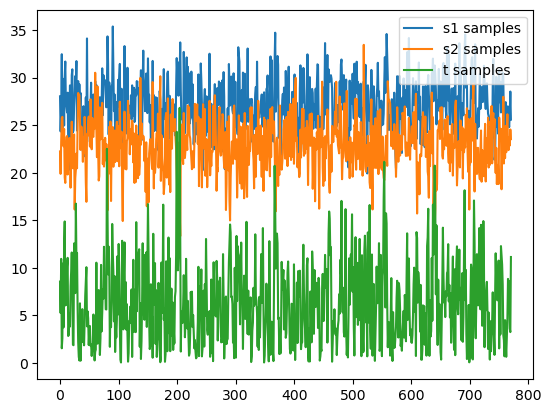

S1 -> Mean: 27.086987983329703, Variance: 7.857041811586416
S2 -> Mean: 22.922009026331885, Variance: 7.7255955188502705


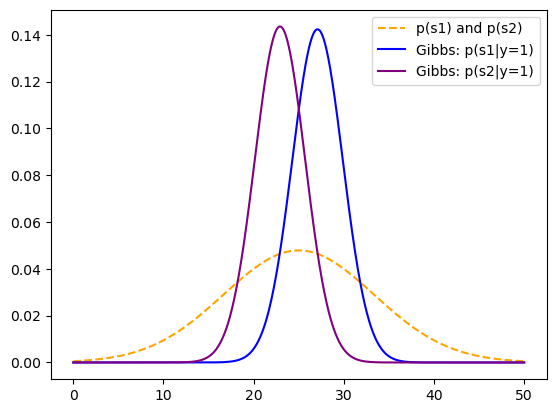

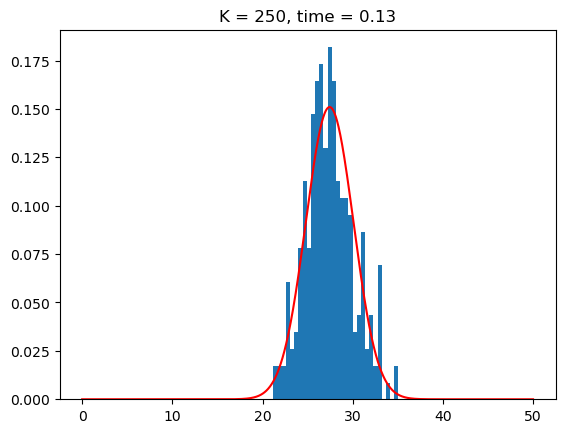

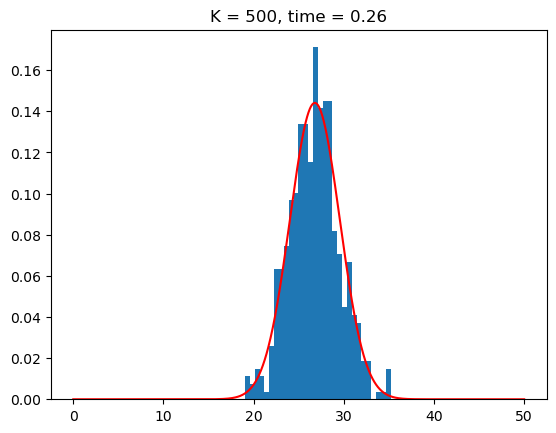

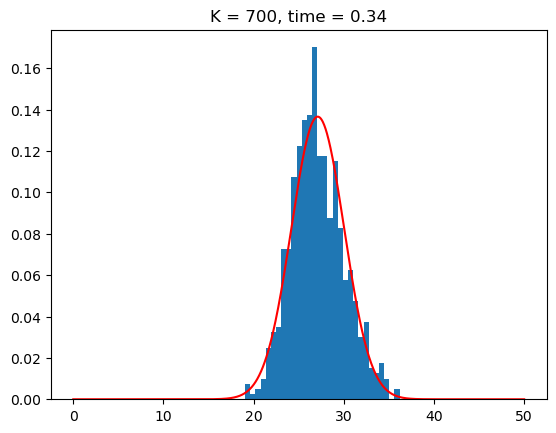

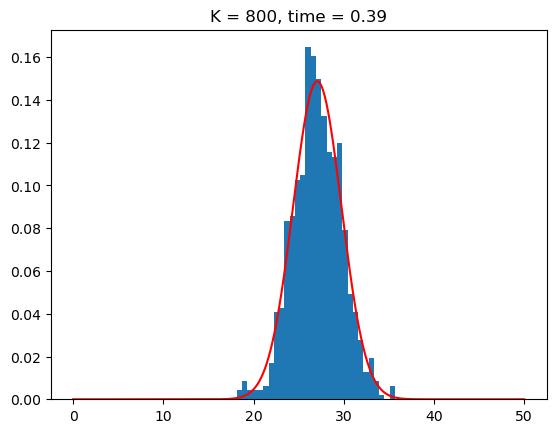

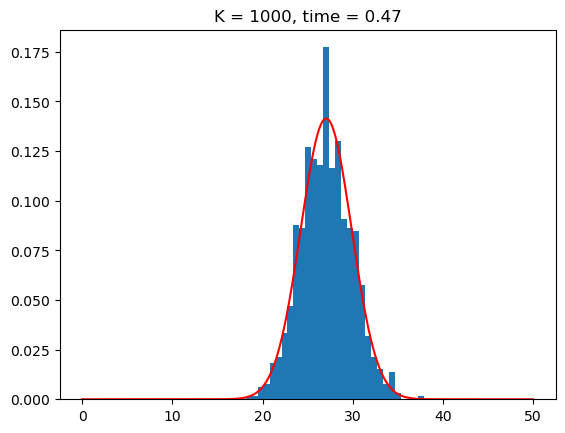

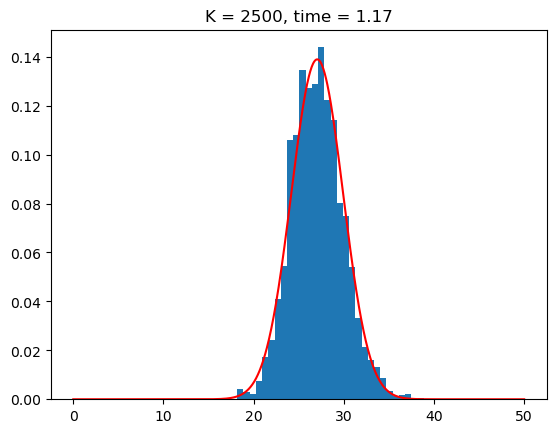

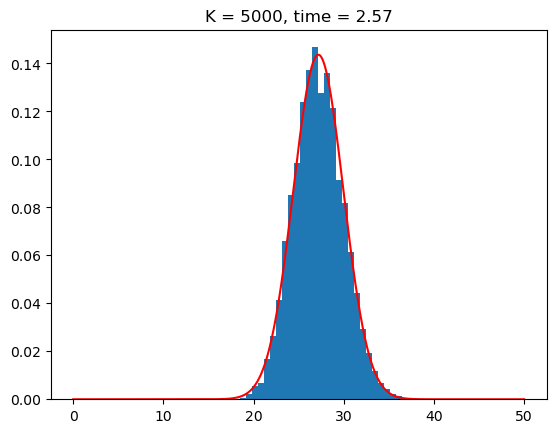

In [22]:
# Q.4 Gibbs sampler, one case where y = 1

# Same hyperparameters for p(s1) and p(s2)
# Default hyperparameter values are from "trueskill.org"
m_s1 = 25
m_s2 = 25
mu_s = np.array([m_s1, m_s2])
var_s1 = 25/3
var_s2 = 25/3
covar_s = np.array([[var_s1, 0], [0, var_s2]])
covar_ts = 25/3
t0 = 30000

# Set number of iterations
K = 800

# Q.4 a) Burn in = 35, after trial and error by having extreme initial conditions
burn_in = 30

# Perform Gibbs sampling (y=1)
s1, s2, t = gibbs(K, mu_s, covar_s, covar_ts, t0, burn_in, 1)


# plot the result
kx = np.linspace(0, K-burn_in,K-burn_in)
plt.plot(kx, s1, label="s1 samples")
plt.plot(kx, s2, label="s2 samples")
plt.plot(kx, t, label="t samples")
plt.legend()
plt.show()
print(f'S1 -> Mean: {np.mean(s1)}, Variance: {np.var(s1)}\nS2 -> Mean: {np.mean(s2)}, Variance: {np.var(s2)}')

# Q.4 b) and d) They look good. p(s1) have an increased mean while the opposite happened to p(s2), this is because
# the initial condition was that y=1, player 1 won, thus that players skill level must increase more than s2.
xx = np.linspace(0, 50, 1000)    
trueskillGaussDist(xx ,s1, s2)

# Q.4 c) k= 600 was choosen because most of the sample values were in the Gaussian distribution and still had
# a good computational time, increasing the k to 1000 didn't make an enough of a difference in accuracy to justify the
# increase int computational time.
performance_check(Klist, mu_s, covar_s, covar_ts, 10, burn_in)

In [26]:
# Used for Q.5 and Q.6

def assume_density(df, K, burn_in, shuffle=False, one_step_predict=False):
    
    # Preprocess the dataframe
    df, clublist = dataPreprocesser(df)
    
    # Shuffle the data randomly (if toggled on)
    if shuffle:
        df = df.sample(frac=1, random_state=np.random.RandomState())
        
    # Initiate variables (if toggled on)
    total_predictions = df.shape[0]
    correct_prediction = 0

    # Iterate through all matches
    for i, row in df.iterrows():
 
        # Set hyperparameters (default values from trueskill.org)
        m_s1 = float(clublist.loc[clublist["club"] == row["team1"],"mean"])
        m_s2 = float(clublist.loc[clublist["club"] == row["team2"],"mean"])
        mu_s = np.array([m_s1, m_s2])  
        var_s1 = float(clublist.loc[clublist["club"] == row["team1"],"variance"])
        var_s2 = float(clublist.loc[clublist["club"] == row["team2"],"variance"])
        covar_s = np.array([[var_s1, 0], [0, var_s2]])
        covar_ts = 25/3
        t0 = 30
        
        # Predict result (if toggled on)
        if one_step_predict:
            prediction = np.sign(m_s1 - m_s2)
            correct_prediction += (prediction == row["result"])
            
        # Perform Gibbs sampling
        s1, s2, t = gibbs(K, mu_s, covar_s, covar_ts, t0, burn_in, row["result"])
      
        # Update hyperparameters
        clublist.loc[clublist["club"] == row["team1"],"mean"] = np.mean(s1)
        clublist.loc[clublist["club"] == row["team2"],"mean"] = np.mean(s2)
        clublist.loc[clublist["club"] == row["team1"],"variance"] = np.var(s1)
        clublist.loc[clublist["club"] == row["team2"],"variance"] = np.var(s2)
    
    # Print results
    print(tabulate(clublist.sort_values(by="mean", ascending=False), headers="keys", tablefmt="psql"))
    print(f'Correct predictions:\t{correct_prediction}\nTotal predictions:\t{total_predictions}\nPrediction rate (r):\t{correct_prediction / total_predictions}')

df = pd.read_csv("SerieA.csv")
K = 800
burn_in = 30
    
assume_density(df, K, burn_in, True, True)

+----+------------+-------+--------+---------+------------+
|    | club       |   win |   loss |    mean |   variance |
|----+------------+-------+--------+---------+------------|
|  7 | Juventus   |    28 |      4 | 33.2938 |    5.6973  |
| 13 | Milan      |    19 |      8 | 33.2344 |   13.2327  |
|  5 | Bologna    |    11 |     16 | 30.6537 |    8.89969 |
|  6 | Atalanta   |    20 |      9 | 30.5471 |    6.86641 |
|  8 | Napoli     |    24 |      7 | 30.5448 |    9.08516 |
| 11 | Genoa      |     8 |     16 | 29.8154 |    6.42703 |
| 16 | Inter      |    20 |      9 | 29.7561 |    8.77965 |
| 14 | Parma      |    10 |     17 | 28.3738 |    8.51536 |
|  2 | Torino     |    16 |      7 | 27.0267 |    9.25713 |
|  3 | Sassuolo   |     9 |     13 | 25.7542 |   11.1624  |
| 18 | Roma       |    18 |      8 | 25.4145 |   10.7671  |
|  4 | Empoli     |    10 |     20 | 24.0052 |    7.97922 |
|  9 | Spal       |    11 |     18 | 23.185  |    7.6983  |
| 12 | Fiorentina |     8 |     13 | 22.

In [50]:
# Moment matching 

# Property 3 in Gauss formula cheet
def multiplyGaussian(mu1, mu2, var1, var2):
    
    var = (var1 * var2) / (var2 + var1)
    mu = (mu1*var2 + mu2*var1) / (var2 + var1)
    
    return mu, var

# Property 4 in Gauss formula cheet
def divideGaussian(mu1, mu2, var1, var2):
    
    var = (var1 * var2) / (var2 - var1)
    mu = (mu1*var2 + mu2*var1) / (var2 - var1)
    
    return mu, var
    
# Truncated Gaussian
def truncatedGaussian(mu, var, y):
    
    if y == 1:
        ing1 = 0
        ing2 = np.Inf
        
    elif y == -1:
        ing1 = -np.Inf
        ing2 = 0
        
    mu_trunc = stats.truncnorm.mean((ing1 - mu) / var, (ing2 - mu) / var, loc=mu, scale=np.sqrt(var))
    var_trunc = stats.truncnorm.mean((ing1 - mu) / var, (ing2 - mu) / var, loc=mu, scale=np.sqrt(var))
    
    return mu_trunc, var_trunc

def moment_matching(A, mu_s, covar_s, covar_ts, y):
    
    # Corollary 2
    mu_fct = A @ mu_s
    var_fct = covar_ts + A @ covar_s @ A[:,None]
    
    # Create truncated gaussian
    mu_trunc, var_trunc = truncatedGaussian(mu_fct, var_fct, y)
    
    # Division
    mu_tfc, var_tfc = divideGaussian(mu_trunc, mu_fct, var_trunc, var_fct)

    # Corollary 2
    mu_fcs1 = A @ np.array([mu_s[0], mu_tfc[0]])
    var_fcs1 = covar_ts + A @ np.diag([covar_s.diagonal()[0], var_tfc]) @ A[:,None]
    
    mu_fcs2 = A @ np.array([mu_s[1], -mu_tfc[0]])
    var_fcs2 = covar_ts + A @ np.diag([covar_s.diagonal()[1], var_tfc]) @ A[:,None]
    print(mu_tfc)
    
    mu_s1F, var_s1F = multiplyGaussian(mu_s[0], mu_fcs1, covar_s.diagonal()[0], var_fcs1)
    mu_s2F, var_s2F = multiplyGaussian(mu_s[1], mu_fcs2, covar_s.diagonal()[1], var_fcs2)
    
    return mu_s1F, mu_s2F, var_s1F, var_s2F
    
    

# Initialize hyperparameters    
A = np.array([1, -1])
mu_s1 = 25
mu_s2 = 25
mu_s = np.array([m_s1, m_s2])
var_s1 = 25/3
var_s2 = 25/3
covar_s = np.array([[var_s1, 0], [0, var_s2]])
covar_ts = 25/3
t0 = 3
    
moment_matching(A, mu_s, covar_s, covar_ts, 1)

[4.74692195]


/home/simon/anaconda3/lib/python3.9/site-packages/numpy/lib/twodim_base.py:289: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  v = asanyarray(v)


(array([array([23.6701924])], dtype=object),
 array([array([26.3298076])], dtype=object),
 array([array([5.99882476])], dtype=object),
 array([array([5.99882476])], dtype=object))

In [19]:
covar_s.diagonal()[1]

8.333333333333334

In [48]:
np.diag([1, 3])

array([[1, 0],
       [0, 3]])